## Setup

In [1]:
# !pip install docplex

In [2]:
from docplex.mp.model import Model

import numpy as np
from numpy import sqrt
import matplotlib.pyplot as plt 

from plot_solution import plot_solution

## Some functions that will be needed

In [3]:
# Calculate the total flow between every pair of nodes given allocated variables from the solution
def get_flow(X_allocated, Y_allocated, Z_allocated):
  flow = np.zeros((n,n))

  # Add up Zik 
  for i in Range:
    for k in Range:
      flow[i,k] += Z_allocated[i,k]
  
  # Add up Xilj
  for i in Range:
    for l in Range:
      for j in Range:
        flow[l,j] += X_allocated[i,l,j]

  # Add up Yikl
  for i in Range:
    for k in Range:
      for l in Range:
        flow[k,l] += Y_allocated[i,k,l]

  return flow

In [4]:
# TODO (there is sth wrong with this method)
# Calculate optimal paths between node pairs for given allocated variables from the solution
def get_paths(X_allocated, Y_allocated, Z_allocated):
  # path for every pair of nodes 
  paths = {}
  for i in Range:
    for j in Range:
      if i == j:
        continue
      # node-hub pairs
      node_hub_pairs = [(i,k) for k in Range if Z_allocated[i,k] > 0]
      hubs_after_i = [node_hub_pair[1] for node_hub_pair in node_hub_pairs]
      # hub-hub pairs orgiginating form i
      hub_hub_pairs = [(k,l) for k in Range for l in Range if Y_allocated[i,k,l] > 0]
      # hub-node pairs originating from i destinating in j
      hub_node_pairs = [(k,j) for k in Range if X_allocated[i,k,j] > 0]
      assert len(hub_node_pairs) == 1
      hub_before_j =  hub_node_pairs[0][0]

      # optimal path form i to j
      path = []
      if hub_before_j is i:
        path = [i, j]
      elif (i,hub_before_j) in node_hub_pairs:
        path = [i, hub_before_j, j]
      else:
        for hub_after_i in hubs_after_i:
          if (hub_after_i, hub_before_j) in hub_hub_pairs:
            path = [i, hub_after_i, hub_before_j, j]
      
      # exclude repeating nodes
      path = sorted(set(path), key=path.index)

      paths[(i,j)] = path
  return paths

In [5]:
# Methods for solution validation
# For given paths calculate the overal cost
def total_cost_from_paths(paths):
  total_cost = 0
  for start, end in paths:
    path = paths[start, end]
    for i in range(len(path)-1):
      node = path[i]
      next_node = path[i+1]
      connection_cost = C[node, next_node]*W[start, end]
      if node in Hubs and next_node in Hubs:
        connection_cost *= alpha
      total_cost += connection_cost
  return total_cost

# For given flow calculate the overal cost
def total_cost_from_flow(flow):
  r = np.multiply(flow, C, W)
  hub_nodes = np.where(np.array(Hubs) > 0)[0]
  for h in hub_nodes:
    for k in hub_nodes:
      r[h,k] *= alpha
  return np.sum(r)

## Problem paramteres

In [6]:
# C should be calculated from the points, but I had values from C in the paper
points = [(0,0), (0,4), (1,5), (3,0), (5,1)]
point_names = ['A', 'B','C', 'D', 'E']

In [7]:
# number of nodes
n = 5
Range = range(n)

In [8]:
alpha = 0.75
p = 2

In [9]:
# distance
C = np.matrix([[0, 4, sqrt(26), 3, sqrt(26)], 
               [4, 0, sqrt(2), 5, sqrt(34)],
               [sqrt(26), sqrt(2), 0, sqrt(29), 4*sqrt(2)],
               [3, 5, sqrt(29), 0, sqrt(5)],
               [sqrt(26), sqrt(34), 4*sqrt(2), sqrt(5), 0]])
C

matrix([[0.        , 4.        , 5.09901951, 3.        , 5.09901951],
        [4.        , 0.        , 1.41421356, 5.        , 5.83095189],
        [5.09901951, 1.41421356, 0.        , 5.38516481, 5.65685425],
        [3.        , 5.        , 5.38516481, 0.        , 2.23606798],
        [5.09901951, 5.83095189, 5.65685425, 2.23606798, 0.        ]])

In [10]:
# demand
W = np.ones((n,n))
for i in range(n):
  W[i,i] = 0 
W

array([[0., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1.],
       [1., 1., 0., 1., 1.],
       [1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 0.]])

## Solve using CPLEX

In [11]:
# create one model instance, with a name
M = Model(name='UMApHMP')

In [12]:
X = {(i,l,j): M.continuous_var(name='X_{0}_{1}_{2}'.format(i,l,j)) for i in Range for l in Range for j in Range} # define X^{i}_{lj}

In [13]:
Y = {(i,k,l): M.continuous_var(name='Y_{0}_{1}_{2}'.format(i,k,l)) for i in Range for k in Range for l in Range} # define Y^{i}_{kl}

In [14]:
Z ={(i,k): M.continuous_var(name='Z_{0}_{1}'.format(i,k)) for i in Range for k in Range} # define Zik

In [15]:
H = {k: M.binary_var(name='H_{0}'.format(k)) for k in Range} # define Hk

In [16]:
M.add_constraint(M.sum(H[k] for k in Range) == p) # (2)

docplex.mp.LinearConstraint[](H_0+H_1+H_2+H_3+H_4,EQ,2)

In [17]:
for i in Range:
  M.add_constraint(M.sum(Z[i,k] for k in Range) == M.sum(W[i,j] for j in Range)) # (3)

In [18]:
for i in Range:
  for j in Range:
    M.add_constraint(M.sum(X[i,l,j] for l in Range) == W[i,j]) # (4)

In [19]:
for i in Range:
  for k in Range:
    M.add_constraint(M.sum(Y[i,k,l] for l in Range) + M.sum(X[i,k,j] for j in Range) - M.sum(Y[i,l,k] for l in Range) - Z[i,k] ==  0) # (5)

In [20]:
for i in Range:
  for k in Range:
    M.add_constraint(Z[i,k] <= H[k]*M.sum(W[i,j] for j in Range)) # (6)

In [21]:
for l in Range:
  for j in Range:
    M.add_constraint(M.sum(X[i,l,j] for i in Range) <= H[l]*M.sum(W[i,j] for i in Range)) # (7)

In [22]:
# X, Y, Z >= 0 and Hk is binary are already met # (8)

In [23]:
M.minimize(M.sum((M.sum(C[i,k]*Z[i,k] for k in Range) + 
                  alpha*M.sum(M.sum(C[k,l]*Y[i,k,l] for l in Range) for k in Range) + 
                  M.sum(M.sum(C[l,j]*X[i,l,j] for j in Range) for l in Range)) for i in Range)) # (1)

In [24]:
M.print_information()

Model: UMApHMP
 - number of variables: 280
   - binary=5, integer=0, continuous=275
 - number of constraints: 106
   - linear=56, quadratic=50
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP


In [25]:
solution = M.solve()

In [26]:
if solution:
  solution.display()
else:
  print("Problem is unfeasible or CPLEX failed to find the solution!")

solution for: UMApHMP
objective: 86.582
status: OPTIMAL_SOLUTION(2)
X_0_1_1 = 1.000
X_0_1_2 = 1.000
X_0_3_3 = 1.000
X_0_3_4 = 1.000
X_1_1_0 = 1.000
X_1_1_2 = 1.000
X_1_1_4 = 1.000
X_1_3_3 = 1.000
X_2_1_0 = 1.000
X_2_1_1 = 1.000
X_2_1_4 = 1.000
X_2_3_3 = 1.000
X_3_1_1 = 1.000
X_3_1_2 = 1.000
X_3_3_0 = 1.000
X_3_3_4 = 1.000
X_4_1_1 = 1.000
X_4_1_2 = 1.000
X_4_3_0 = 1.000
X_4_3_3 = 1.000
Y_1_1_3 = 1.000
Y_2_1_3 = 1.000
Y_3_3_1 = 2.000
Z_0_1 = 2.000
Z_0_3 = 2.000
Z_1_1 = 4.000
Z_2_1 = 4.000
Z_3_3 = 4.000
Z_4_1 = 2.000
Z_4_3 = 2.000
H_1 = 1
H_3 = 1


## Ilustrate the solution

In [27]:
Hubs = [solution.get_var_value(H[i]) for i in Range]
Z_allocated = {(i,k): solution.get_var_value(Z[i,k]) for i in Range for k in Range}
X_allocated = {(i,l,j): solution.get_var_value(X[i,l,j]) for i in Range for l in Range for j in Range}
Y_allocated = {(i,k,l): solution.get_var_value(Y[i,k,l]) for i in Range for k in Range for l in Range}

In [28]:
min_overall_cost = solution.objective_value
min_overall_cost

86.58178798836512

In [29]:
flow = get_flow(X_allocated, Y_allocated, Z_allocated)
flow

array([[0., 2., 0., 2., 0.],
       [2., 8., 4., 2., 2.],
       [0., 4., 0., 0., 0.],
       [2., 2., 0., 8., 2.],
       [0., 2., 0., 2., 0.]])

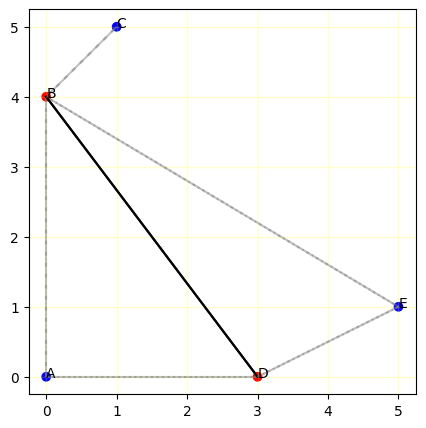

In [30]:
fig, ax = plt.subplots(1, figsize=(5, 5))
plot_solution(ax, points, point_names, Hubs, flow)
plt.show()

In [31]:
paths = get_paths(X_allocated, Y_allocated, Z_allocated)
paths

{(0, 1): [0, 1],
 (0, 2): [0, 1, 2],
 (0, 3): [0, 3],
 (0, 4): [0, 3, 4],
 (1, 0): [1, 0],
 (1, 2): [1, 2],
 (1, 3): [1, 3],
 (1, 4): [1, 4],
 (2, 0): [2, 1, 0],
 (2, 1): [2, 1],
 (2, 3): [2, 1, 3],
 (2, 4): [2, 1, 4],
 (3, 0): [3, 0],
 (3, 1): [3, 1],
 (3, 2): [3, 1, 2],
 (3, 4): [3, 4],
 (4, 0): [4, 3, 0],
 (4, 1): [4, 1],
 (4, 2): [4, 1, 2],
 (4, 3): [4, 3]}

## Validate the solution

In [32]:
total_cost_from_paths(paths)

87.5817879883651

In [33]:
total_cost_from_flow(flow)

86.58178798836511

`total_cost_from_flow(flow)` gives exactly the same value as the algorithm. Looks like solution is valid.

Also, looks like I didn't extract paths well. Flow is easier to calculate and so more reliable.

## Let's enforce  C i D to be the hubs

In [34]:
M.add_constraint(H[2] == 1)
M.add_constraint(H[3] == 1)

docplex.mp.LinearConstraint[](H_3,EQ,1)

In [35]:
solution = M.solve()

In [36]:
Hubs = [solution.get_var_value(H[i]) for i in Range]
Z_allocated = {(i,k): solution.get_var_value(Z[i,k]) for i in Range for k in Range}
X_allocated = {(i,l,j): solution.get_var_value(X[i,l,j]) for i in Range for l in Range for j in Range}
Y_allocated = {(i,k,l): solution.get_var_value(Y[i,k,l]) for i in Range for k in Range for l in Range}

In [37]:
min_overall_cost = solution.objective_value
min_overall_cost

90.53079554728012

In [38]:
flow = get_flow(X_allocated, Y_allocated, Z_allocated)

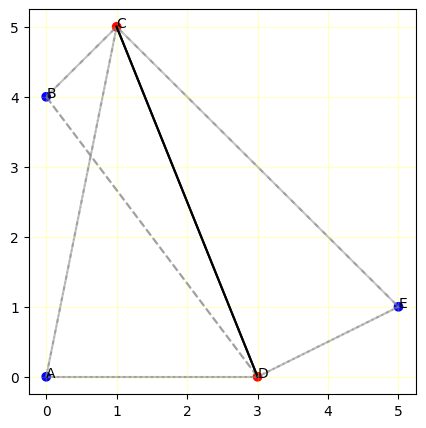

In [39]:
fig, ax = plt.subplots(1, figsize=(5, 5))
plot_solution(ax, points, point_names, Hubs, flow)
plt.show()

In [40]:
paths = get_paths(X_allocated, Y_allocated, Z_allocated)
paths

{(0, 1): [0, 2, 1],
 (0, 2): [0, 2],
 (0, 3): [0, 3],
 (0, 4): [0, 3, 4],
 (1, 0): [1, 2, 0],
 (1, 2): [1, 2],
 (1, 3): [1, 3],
 (1, 4): [1, 2, 4],
 (2, 0): [2, 0],
 (2, 1): [2, 1],
 (2, 3): [2, 3],
 (2, 4): [2, 4],
 (3, 0): [3, 0],
 (3, 1): [3, 1],
 (3, 2): [3, 2],
 (3, 4): [3, 4],
 (4, 0): [4, 3, 0],
 (4, 1): [4, 2, 1],
 (4, 2): [4, 2],
 (4, 3): [4, 3]}

In [41]:
total_cost_from_paths(paths)

416.1359542401605

In [42]:
total_cost_from_flow(flow)

90.53079554728015